In [1]:
# imports
%matplotlib inline
import seaborn as sns
from pyrt.data.data_trots import *
from pyrt.optimization.vmat import *
from pyrt.tools import *


In [2]:
# Troy Inputs - Prostate
# Find work directory
cwd = '/Users/troy/Dropbox/CAP Group/TROTS/Prostate_VMAT/'
working_directory = 't-roy/'
# cwd = '/media/troy/DataDrive/Dropbox/CAP Group/TROTS/Prostate_VMAT/'

# Load patient information
filename = 'Prostate_VMAT_101.mat'


'''
TEST WHY 100 PTV DOESN'T WORK!!!
'''

back_proj_list_of_dicts = [
   {'PTV':30.,'Bladder':15.,'default':0., 'threshold':0.},
    {'PTV':30.,'Rectum':15.,'default':0., 'threshold':0.},
#     {'PTV':5,'default':1, 'threshold':0.},
    {'PTV':100.,'default':1., 'threshold':0.},
    {'PTV':1.,'default':0., 'threshold':0.}
]
    
# back_proj_list_of_dicts = [
#     {'PTV':10,'default':1, 'threshold':0.}
# ]


vmat_model_params = {
    'target_weights':{'PTV':10000., 'default':500.},
    'oar_weights':{'Rectum':10., 'Bladder':10., 'default':1.},
    'min_intensity':0,
    'max_intensity':1000,
    'cp_redundancy':1, 
    'back_projection_dicts':back_proj_list_of_dicts
}


input_dict = {
    'cwd': cwd,
    'figure_directory':working_directory,
    'filename': filename,
    'Rx': {'PTV': 79.56, 'PTV Vesicles': 72.2},
    'model_params':vmat_model_params
}



In [ ]:
# # Troy Inputs - H&N
# # Find work directory
# # cwd = '/Users/troy/Dropbox/CAP Group/TROTS/Prostate_VMAT/'
# working_directory = 'outputs_troy/'
# cwd = '/media/troy/DataDrive/Dropbox/CAP Group/TROTS/Prostate_VMAT/'

# # Load patient information
# filename = 'Prostate_VMAT_101.mat'

# imrt_model_params = {
#     'target_weights':{'PTV':1000., 'default':500.},
#     'oar_weights':{'Rectum':10., 'Bladder':10., 'default':1.}
# }


# input_dict = {
#     'cwd': cwd,
#     'figure_directory':working_directory,
#     'filename': filename,
#     'Rx': {'PTV': 79.56, 'PTV Vesicles': 72.2},
#     'model_params':imrt_model_params
# }

In [ ]:
model = vmat_mip(input_dict)

In [3]:
model = conformal_arc(input_dict)

---------------------
|  Reading in data  |
---------------------
Building Structures
importing PTV Dij as dense matrix, converting to sparse...
importing PTV Shell 50 mm Dij as dense matrix, converting to sparse...
importing External Ring 20 mm Dij as sparse matrix
importing PTV Shell 5 mm Dij as dense matrix, converting to sparse...
importing PTV Shell 15 mm Dij as dense matrix, converting to sparse...
importing PTV Shell 25 mm Dij as dense matrix, converting to sparse...
importing Rectum Dij as dense matrix, converting to sparse...
importing Anus Dij as dense matrix, converting to sparse...
importing Hip (L) Dij as dense matrix, converting to sparse...
importing Hip (R) Dij as dense matrix, converting to sparse...
importing Bladder Dij as dense matrix, converting to sparse...
importing Patient Dij as dense matrix, converting to sparse...
Building CP
----------------------------
|  Data reading completed  |
----------------------------


In [4]:
model.optimize(display=5,UB=1000.)


Solver Starting...
conf_arc model solved in 1.53498601913 seconds


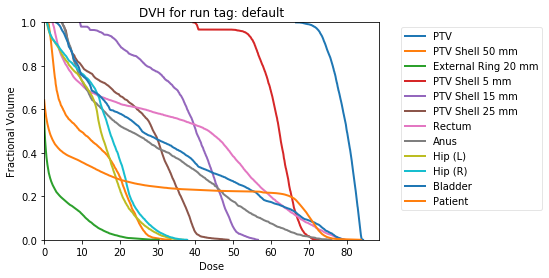

In [5]:
model.plot_DVH(run_tag='default',saveDVH=True)

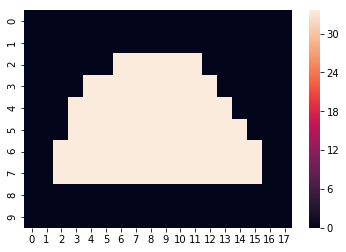

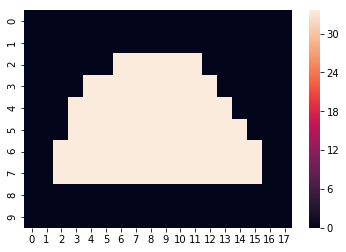

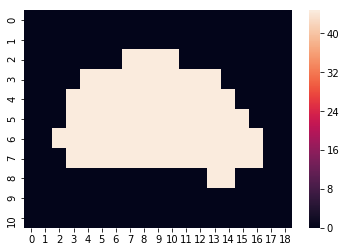

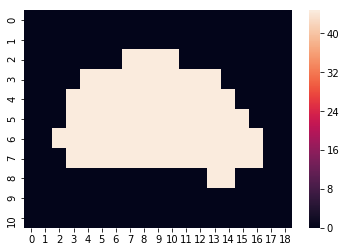

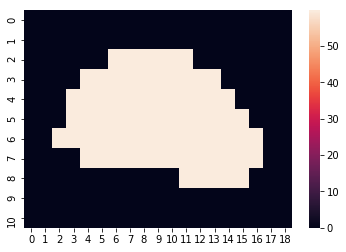

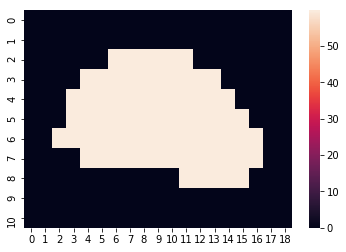

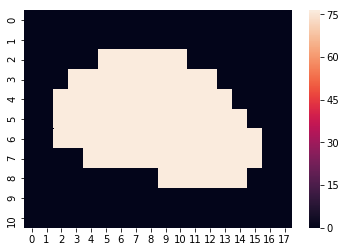

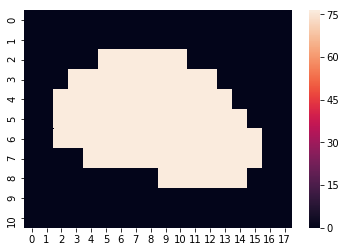

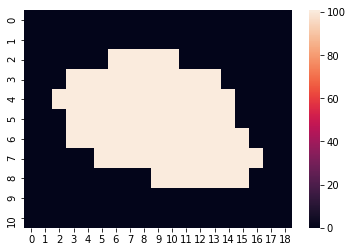

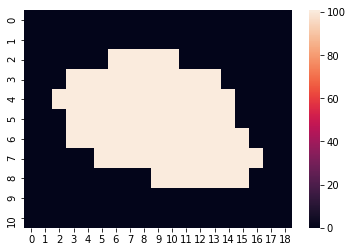

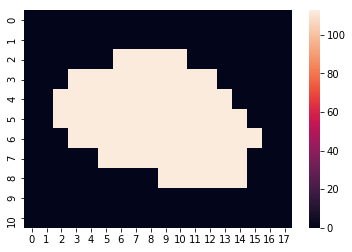

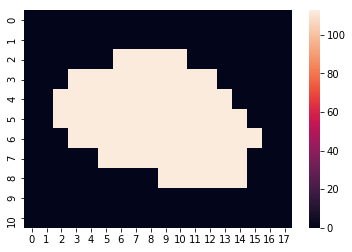

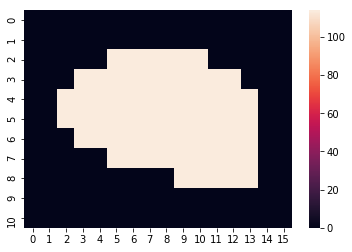

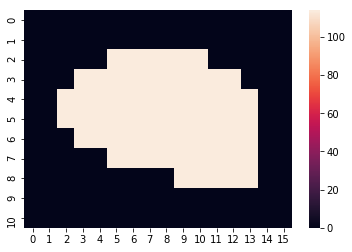

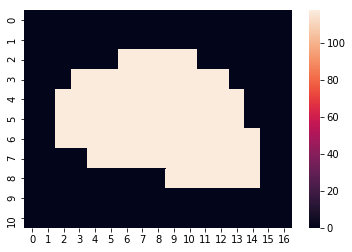

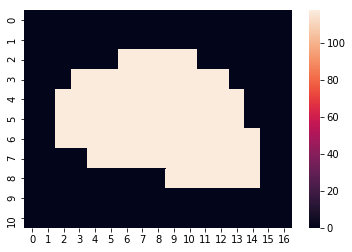

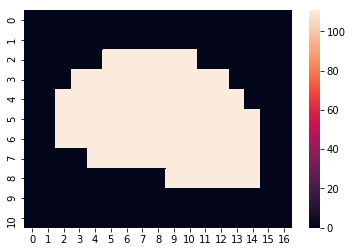

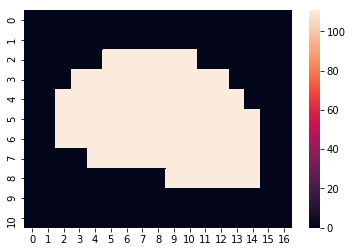

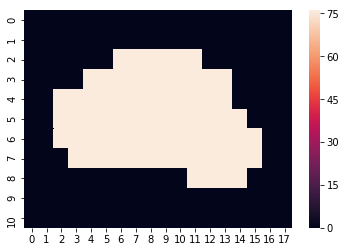

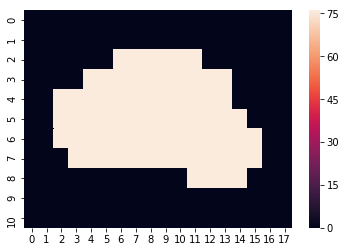

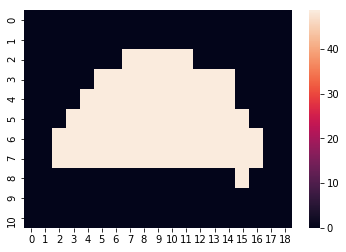

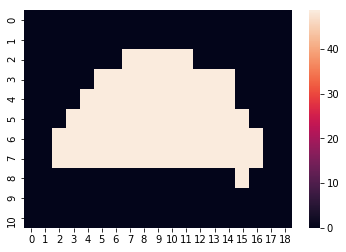

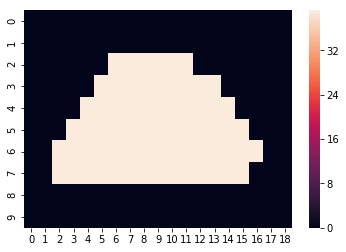

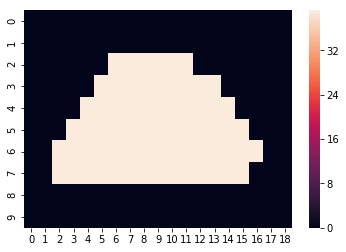

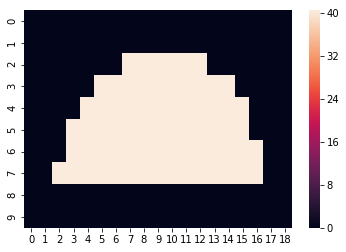

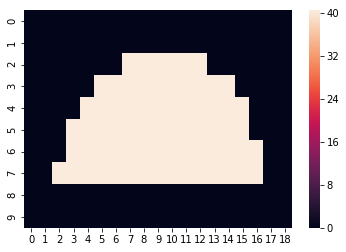

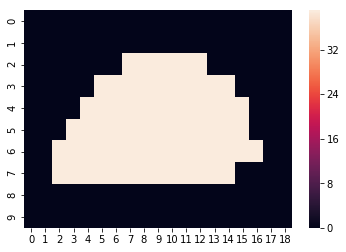

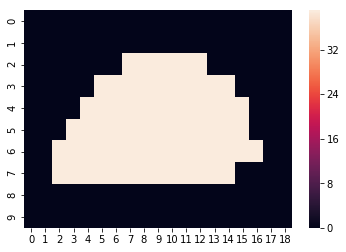

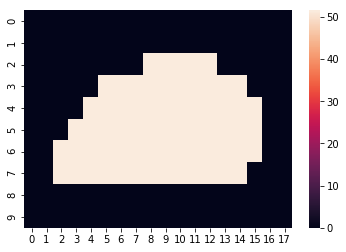

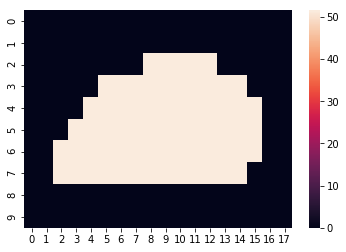

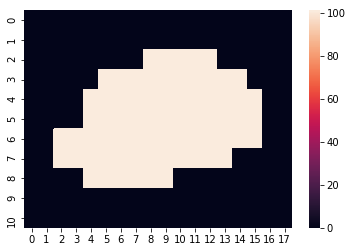

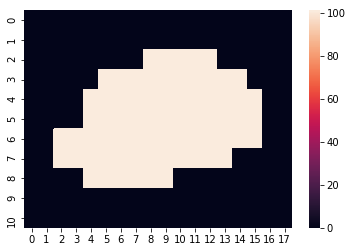

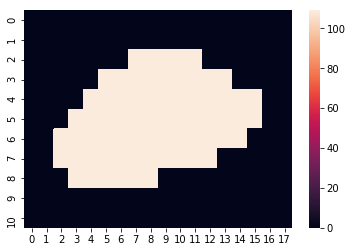

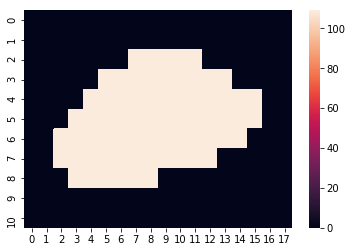

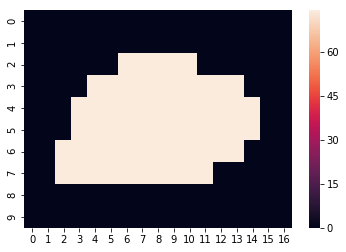

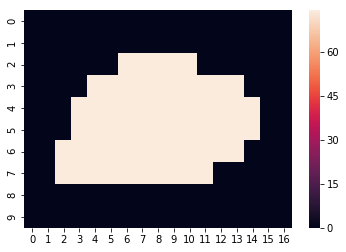

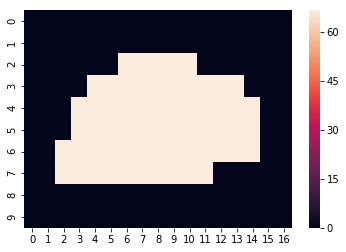

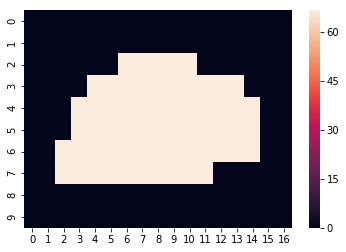

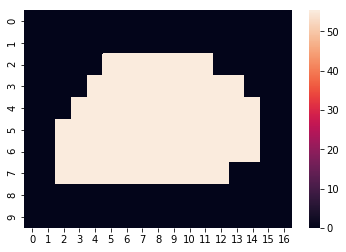

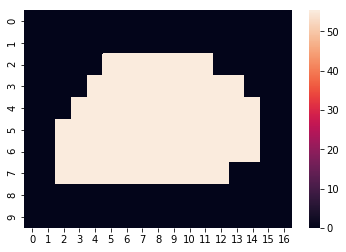

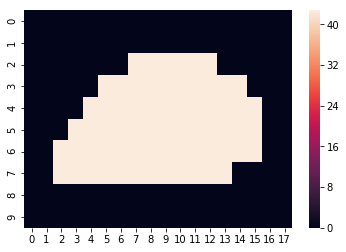

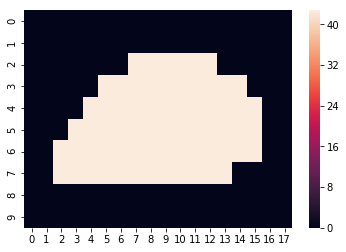

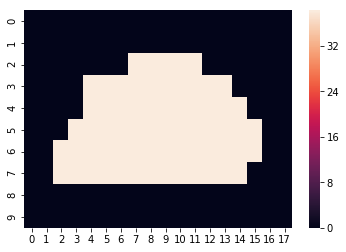

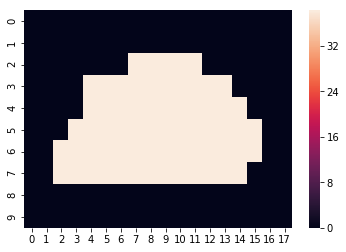

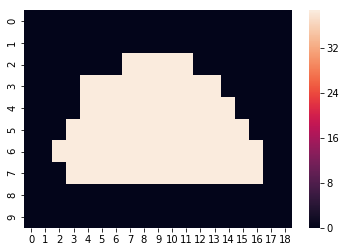

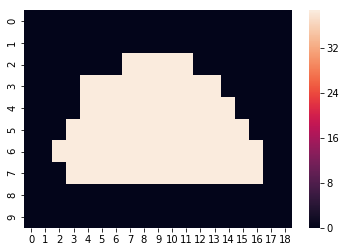

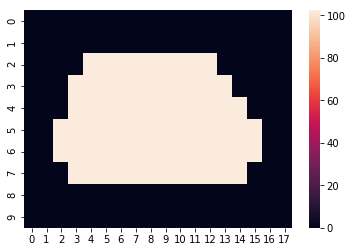

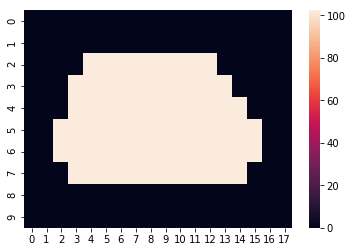

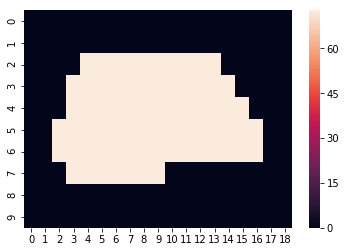

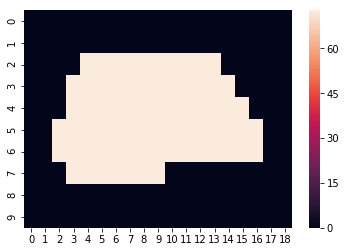

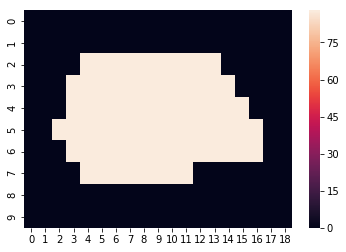

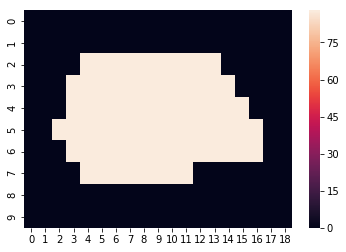

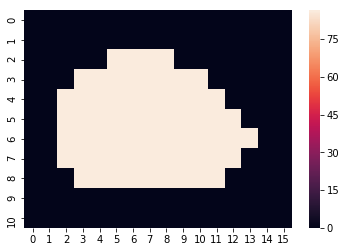

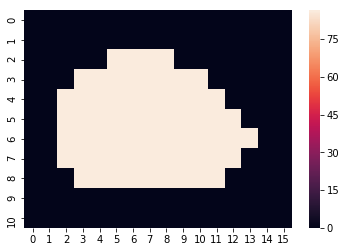

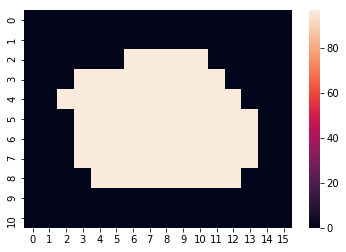

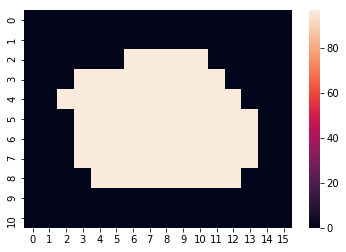

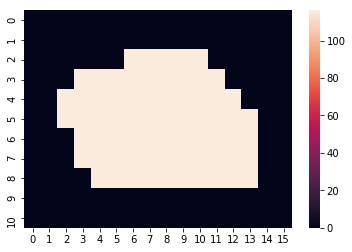

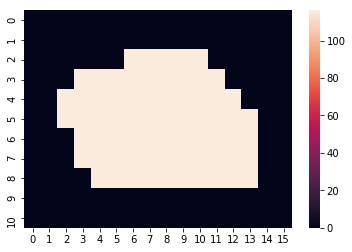

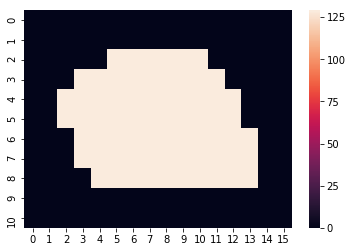

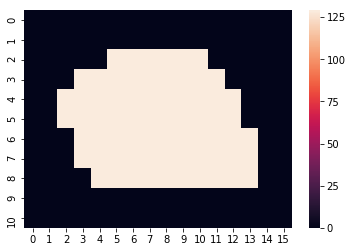

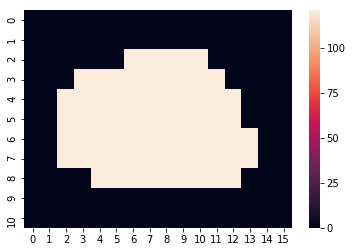

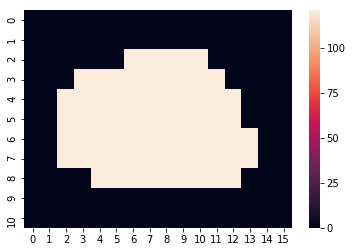

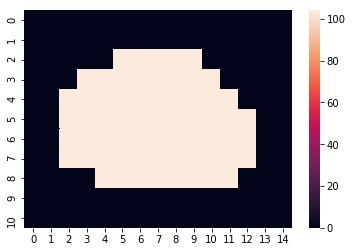

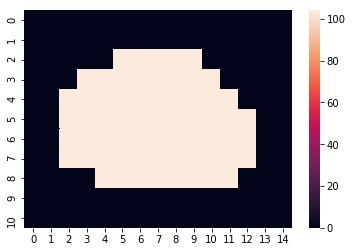

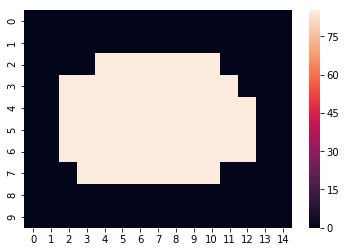

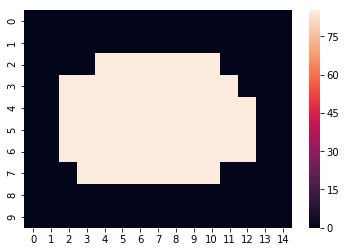

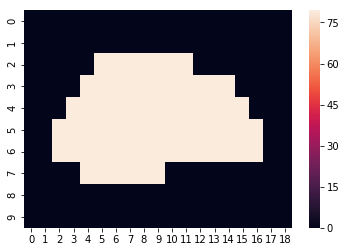

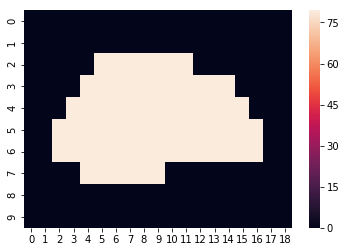

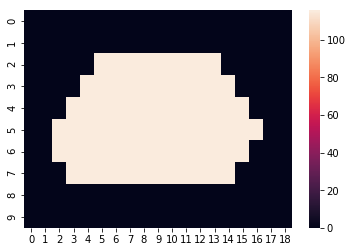

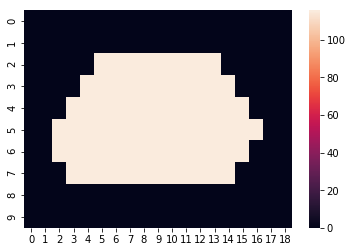

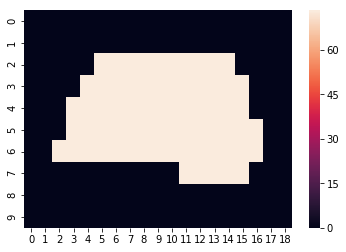

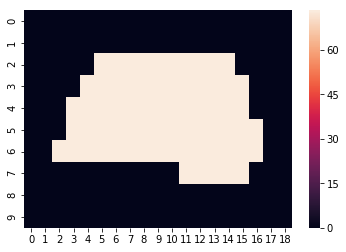

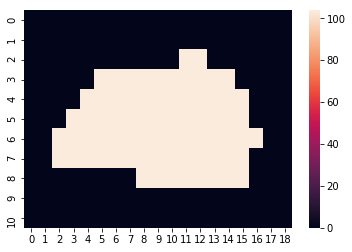

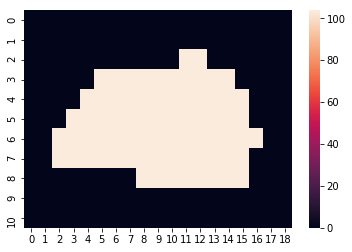

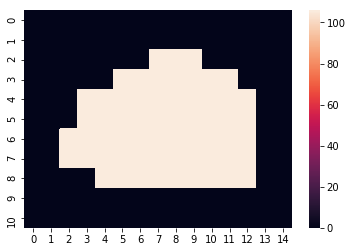

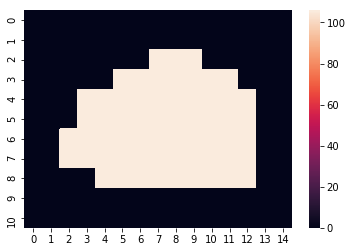

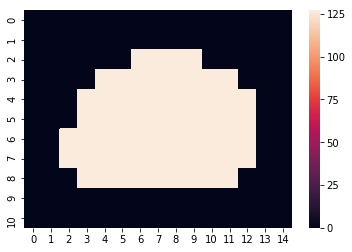

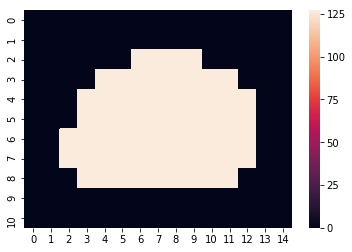

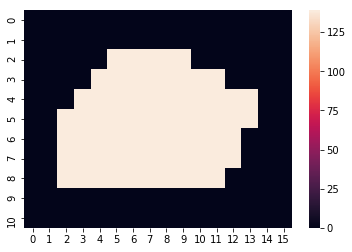

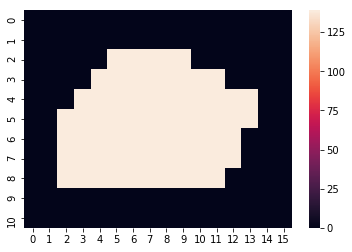

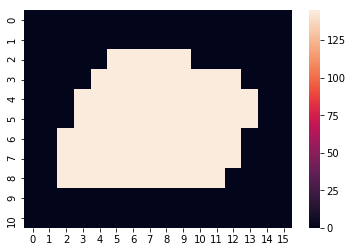

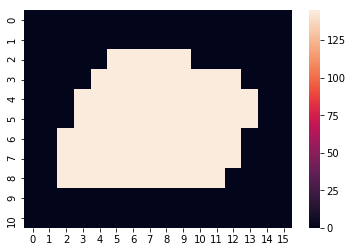

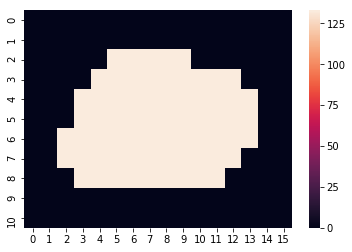

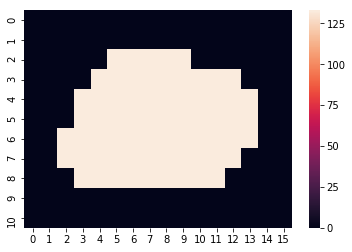

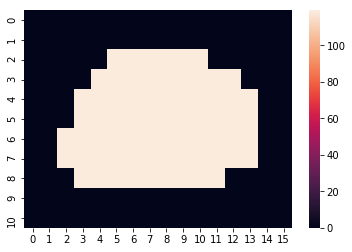

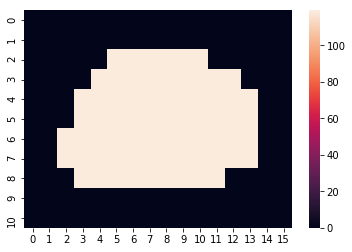

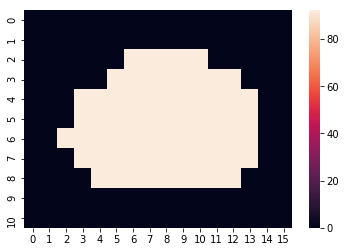

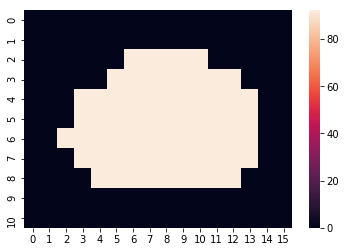

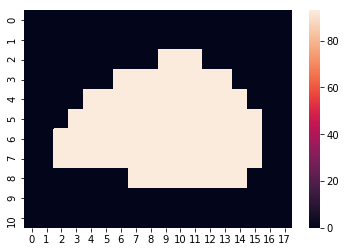

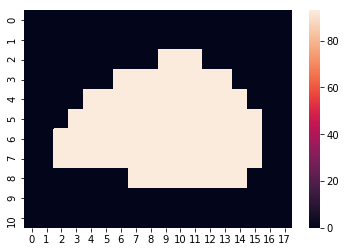

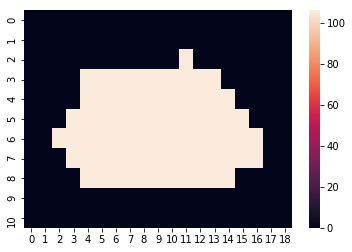

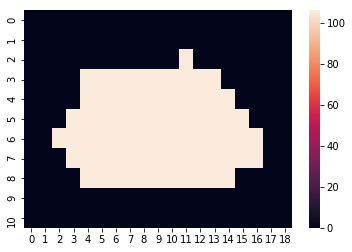

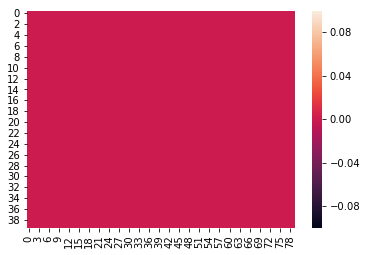

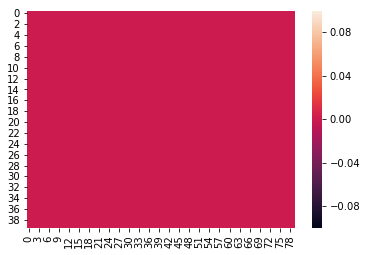

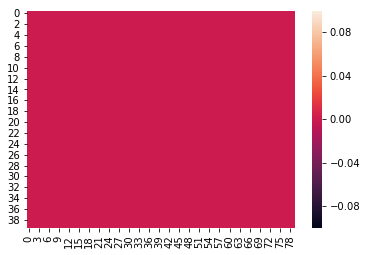

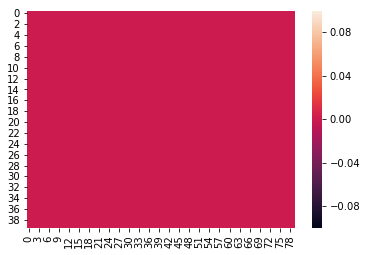

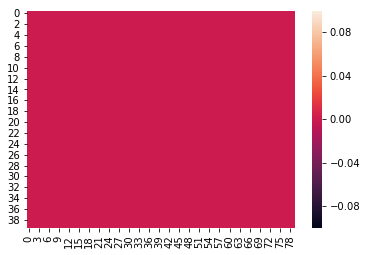

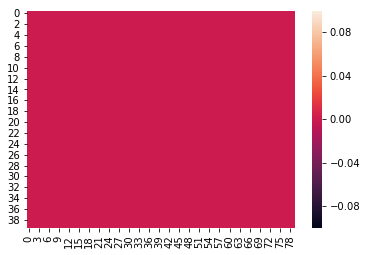

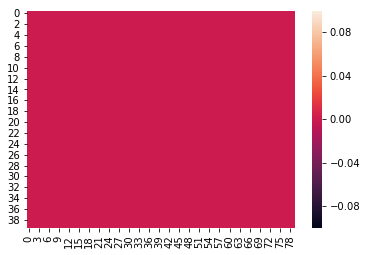

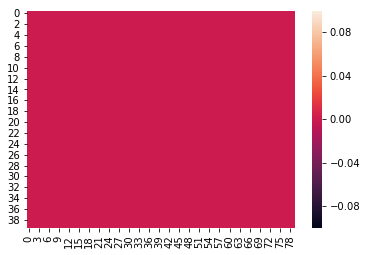

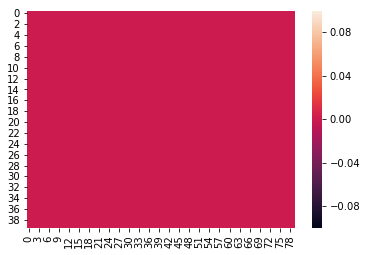

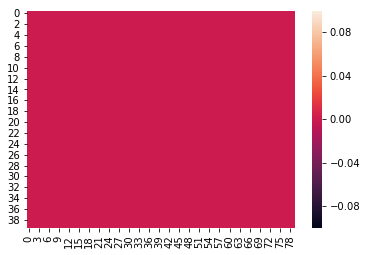

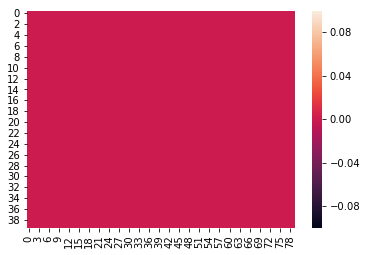

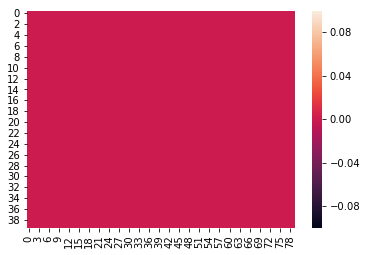

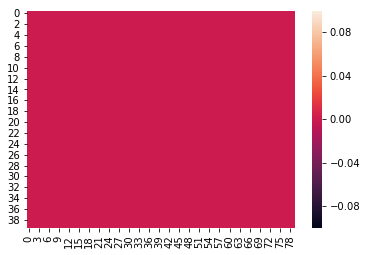

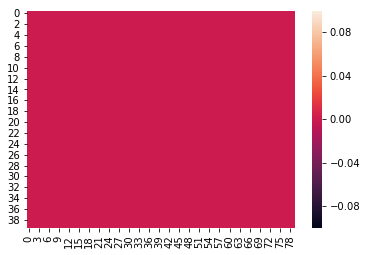

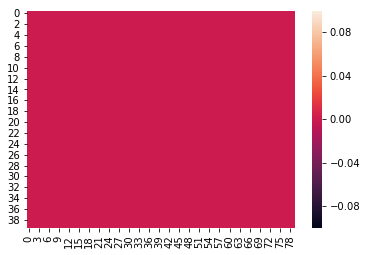

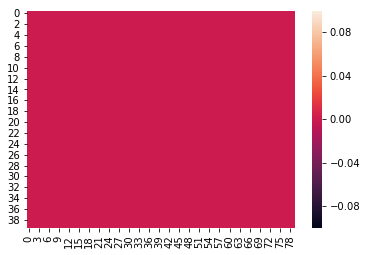

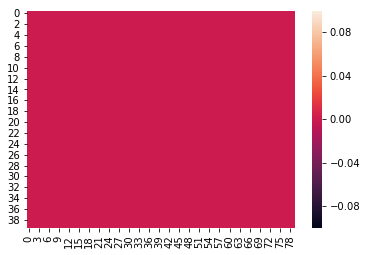

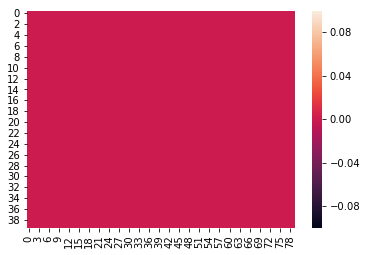

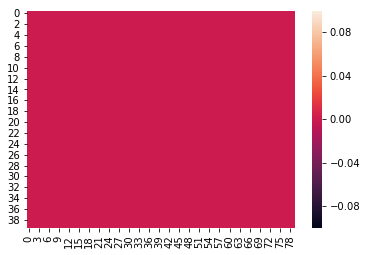

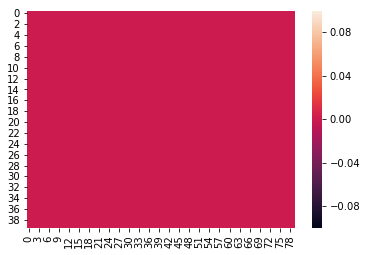

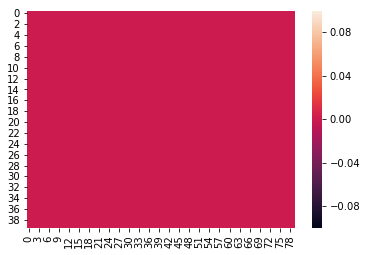

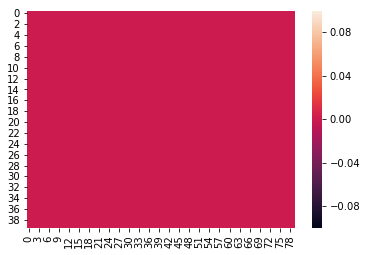

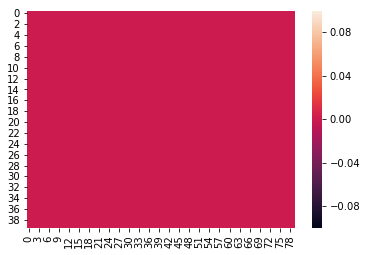

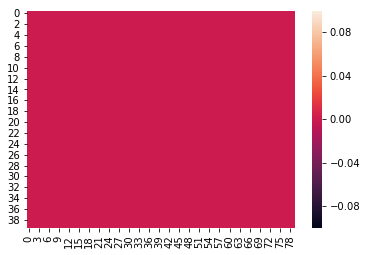

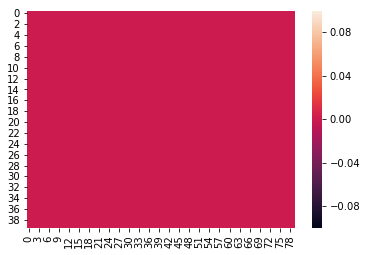

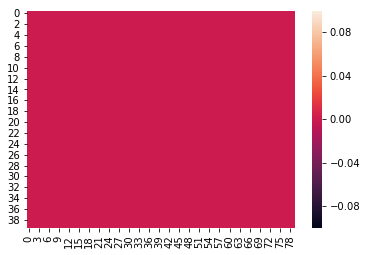

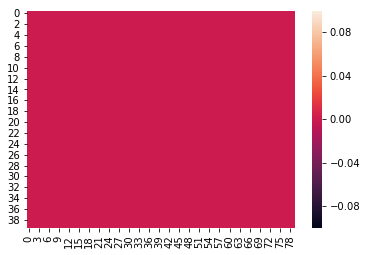

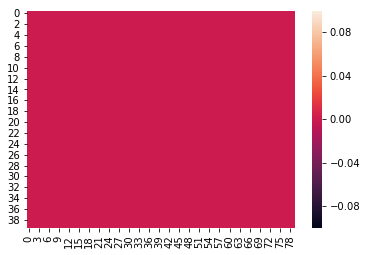

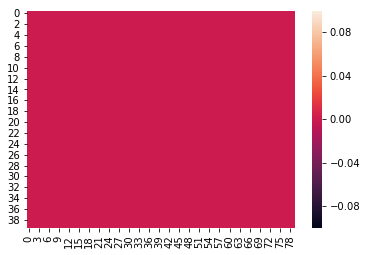

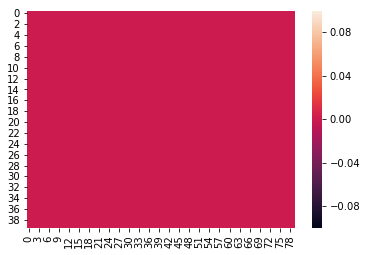

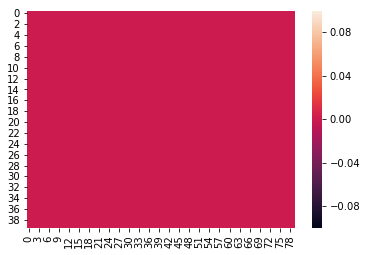

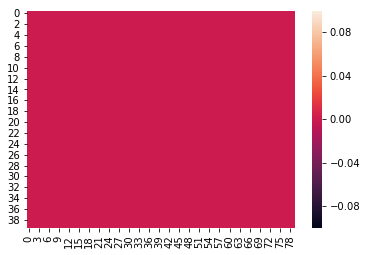

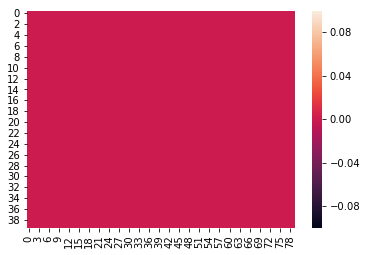

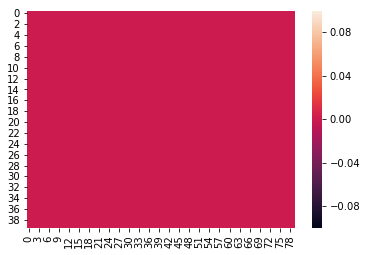

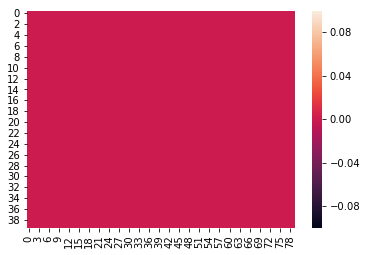

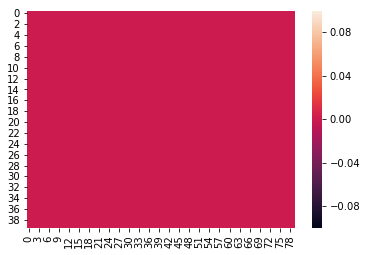

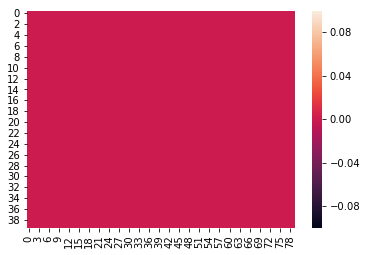

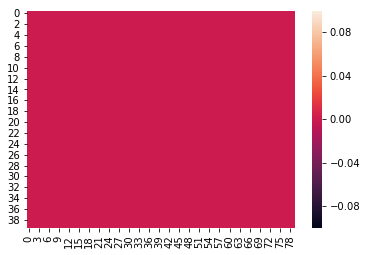

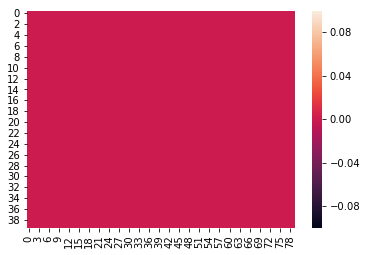

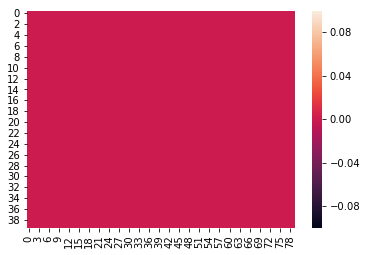

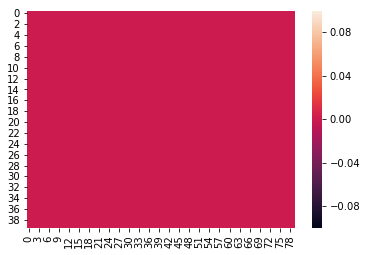

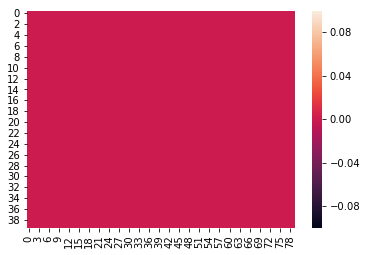

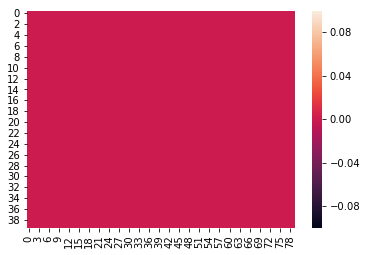

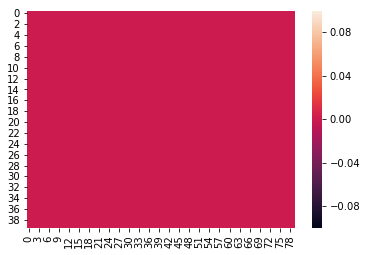

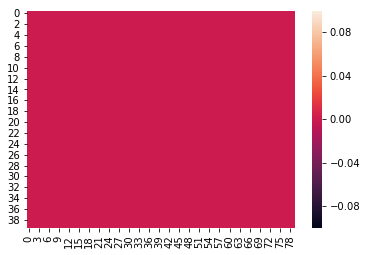

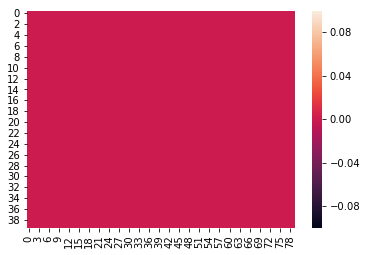

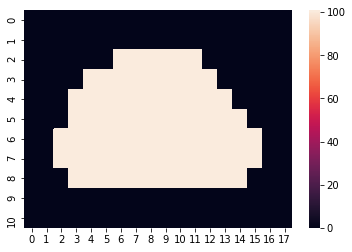

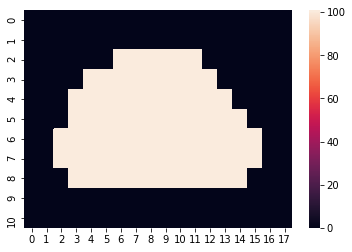

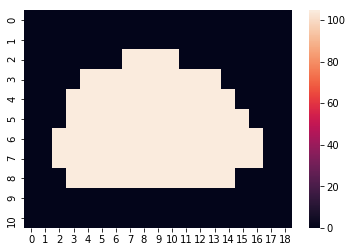

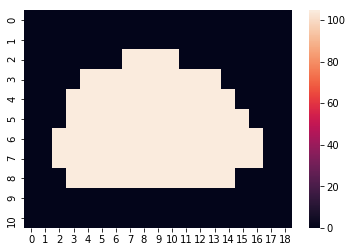

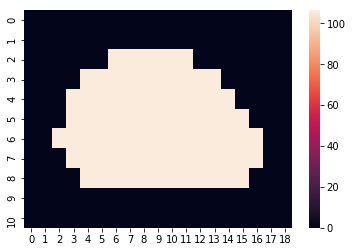

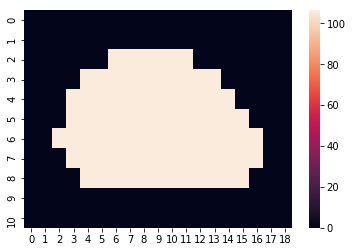

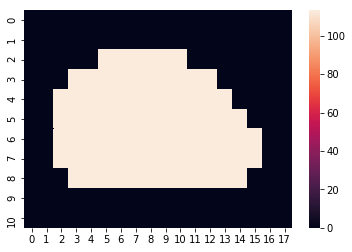

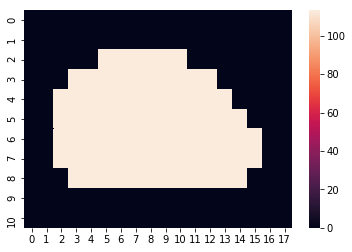

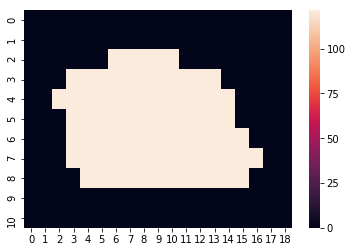

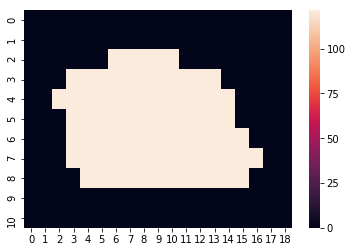

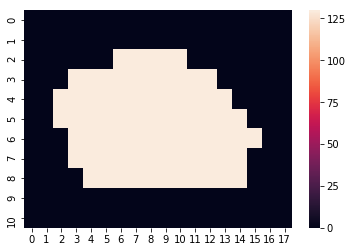

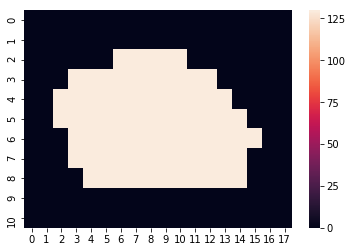

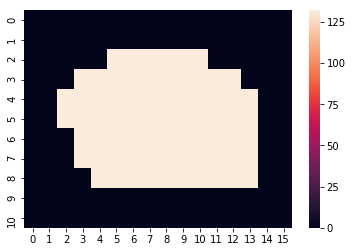

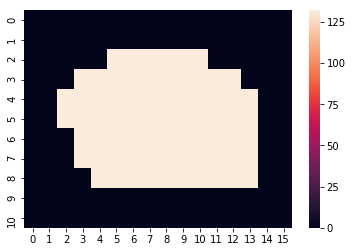

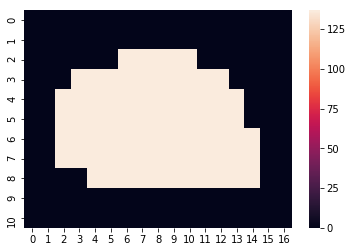

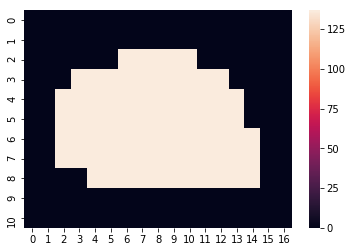

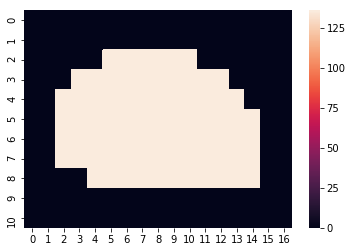

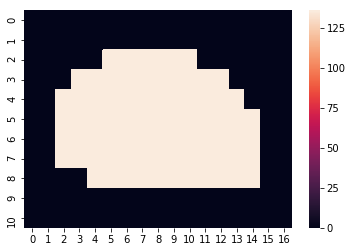

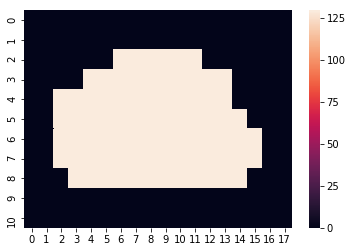

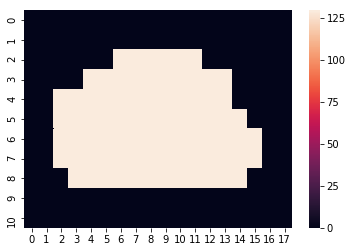

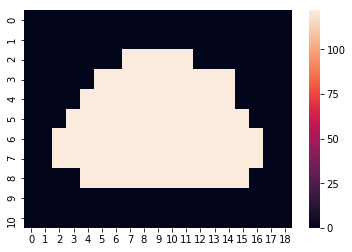

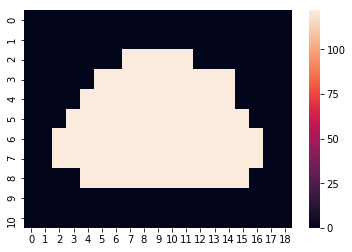

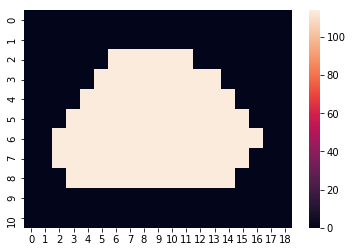

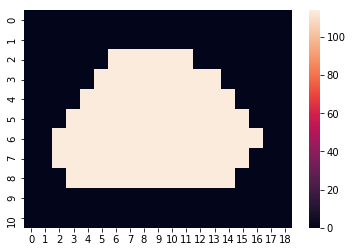

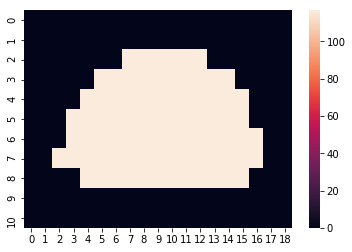

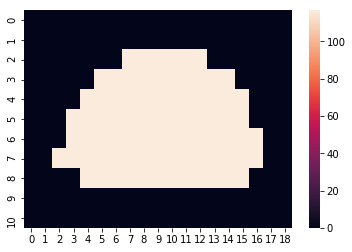

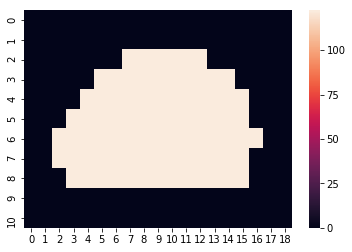

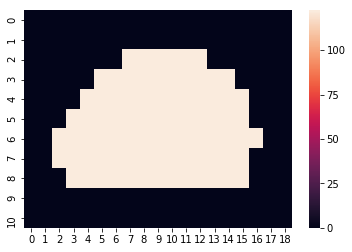

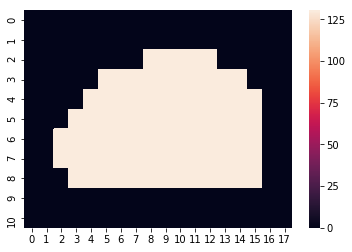

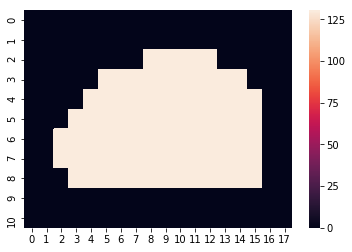

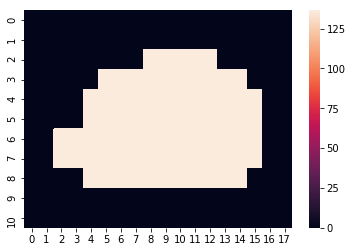

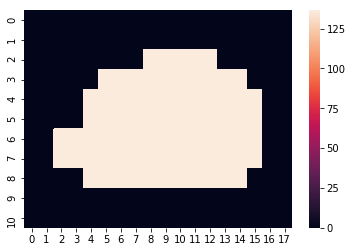

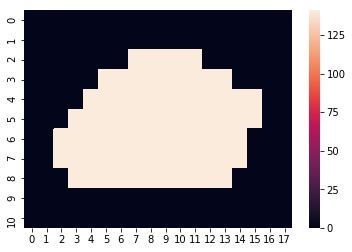

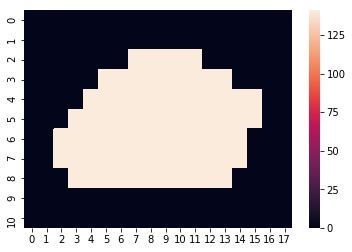

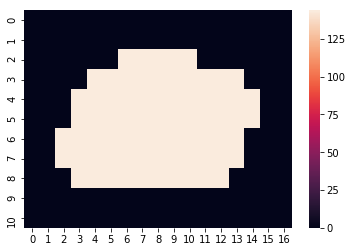

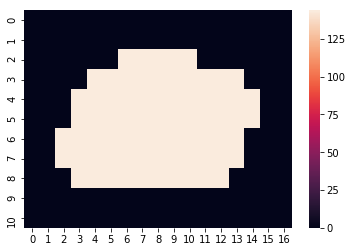

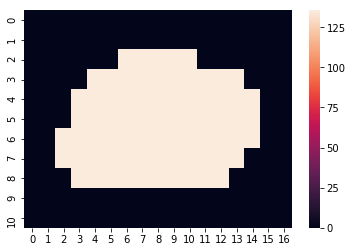

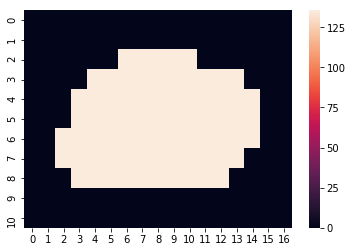

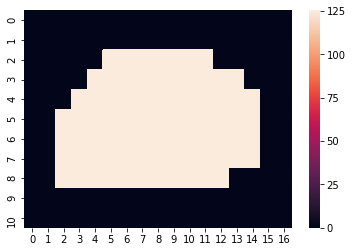

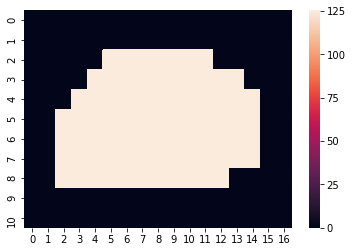

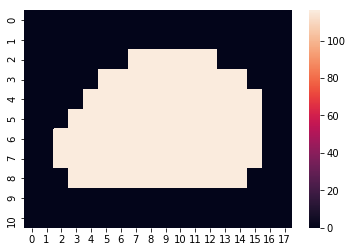

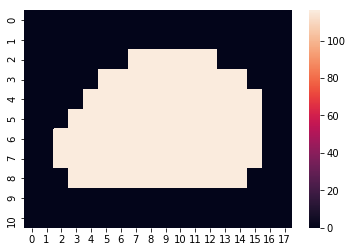

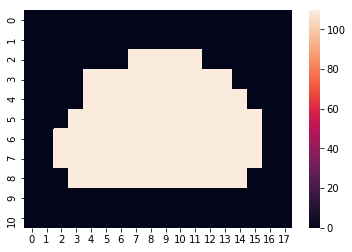

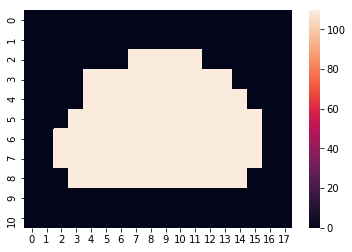

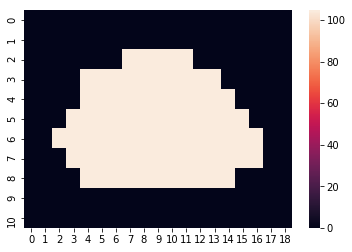

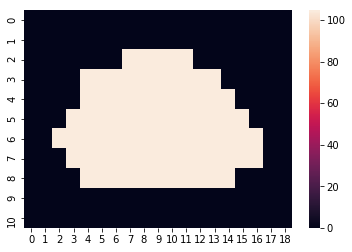

In [6]:
for a in model.apertures:
    plot_aper(a,model.data,str(a.cp_number),save_bool=False,show_plot=True,tight_bool=True, buffer = 2)

In [6]:
model.aper_intensities

array([   0.        ,    0.        ,    0.        ,    0.        ,
         15.96773373,   90.76148876,   39.93443652,  133.71928801,
         69.18998948,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,   39.01795143,
         40.45889768,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,  246.63085192,
          0.        ,   28.78725156,    0.        ,    0.        ,
         83.32970893,  244.37528659,  140.16355875,    0.        ,
          0.        ,    0.        ,  306.89173584,    0.        ,
        125.52095364,    0.        ,   59.78618373,  309.19048268,
        464.45403793,  350.10913263,  187.06061352,    0.        ,
         53.75123351,  327.55928032,    1.        ,    1.        ,
          1.        ,    1.        ,    1.        ,    1.        ,
          1.        ,    1.        ,    1.        ,    1.        ,
          1.        ,    1.        ,    1.        ,    1.     

In [8]:
for a in model.apertures:

    print len(a.beamlet_members)

66
66
70
70
74
74
73
73
73
73
69
69
65
65
69
69
71
71
72
72
70
70
68
68
70
70
69
69
67
67
71
71
69
69
61
61
62
62
66
66
67
67
66
66
68
68
72
72
72
72
72
72
65
65
67
67
69
69
69
69
69
69
64
64
58
58
67
67
74
74
69
69
74
74
61
61
63
63
68
68
68
68
68
68
70
70
67
67
71
71
75
75
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
78
78
81
81
82
82
81
81
80
80
76
76
72
72
76
76
78
78
81
81
81
81
80
80
82
82
83
83
81
81
78
78
76
76
73
73
74
74
79
79
81
81
79
79
79
79


In [ ]:

for c in range(model.data.num_control_points):
    
    new_aper = np.zeros(model.data.control_points[c].number_beamlets)
    value, beamlets = pricing_problem_beam_aper(model.data.control_points[c],beamlet_usefulness[model.data.cumulative_beamlets_per_cp[model.data.control_points[c].org_cp_number]:model.data.cumulative_beamlets_per_cp[model.data.control_points[c].org_cp_number+1]])
    if len(beamlets)>0:
        new_aper[np.array(beamlets)] = 1.

        plot_fluence_map(model.data, 
                             model.data.control_points[c],
                             beamlet_usefulness[model.data.cumulative_beamlets_per_cp[model.data.control_points[c].org_cp_number]:model.data.cumulative_beamlets_per_cp[model.data.control_points[c].org_cp_number+1]],
                            tight_bool=False,
                            save_bool=False,
                        show_plot=True)

        plot_fluence_map(model.data, 
                         model.data.control_points[c],
                         new_aper,
                        tight_bool=False,
                        save_bool=False,
                        show_plot=True)
    

In [ ]:
for a in model.apertures:
    plot_aper(a,model.data,str(a.cp_number),save_bool=False,show_plot=True,tight_bool=True, buffer = 2)

In [ ]:
dose_weight_dict = {'PTV':30, 'Bladder':10}

a = aper_gen_given_dose(dose_weight_dict,model.data, model.data.control_points[0])

plot_aper(a,model.data,'testaper',show_plot=True, save_bool=True,save_name='tester')





